# Curve Pattern Classification : CNN Model (Pure)

In [1]:
from pydemia.manufacture.Lot import wafer as line_wafer
from pydemia.manufacture.new_lot import wafer as arc_wafer
import numpy as np
import pandas as pd
import scipy as sp
import cv2
import skimage as ski
from skimage import filters, transform
import matplotlib.pyplot as plt
import itertools as it
import os
from glob import glob
import tensorflow as tf
from sklearn import model_selection

from skimage.measure import ransac, CircleModel, LineModelND
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral, denoise_wavelet

In [2]:
%matplotlib inline

# Data Preparation

## Bad Data : Pure

Bad Data : 108000
wafer_data/bad_image/augmented_reformed_pure_black/augmented_reformed_pure_black_000001.png


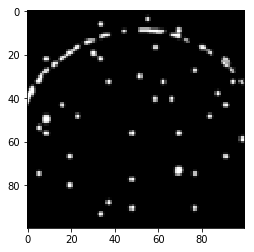

In [3]:
dirname = 'wafer_data/bad_image/augmented_reformed_pure_black'
bad_list = sorted(glob(dirname + '/' + '*.png'))
#bad_data = tuple((1, sp.misc.imread(bad)) for bad in bad_list)
bad_data = tuple((1, sp.misc.imresize(sp.misc.imread(bad), size=(100, 100))) for bad in bad_list)

print('Bad Data : %s' % len(bad_data))
print(bad_list[1])
plt.imshow(bad_data[0][1], cmap='gray')

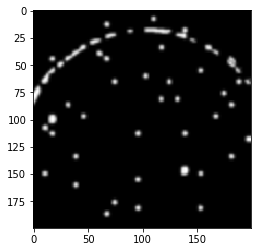

In [4]:
plt.imshow(sp.misc.imresize(bad_data[0][1], size=(200, 200)), cmap='gray')

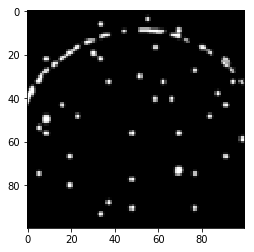

In [5]:
plt.imshow(sp.misc.imresize(bad_data[0][1], size=(100, 100)), cmap='gray')

## Good Data : Pure

Good Data : 72000
wafer_data/good_image/good_reformed_pure_black/good_reformed_pure_black_000001.png


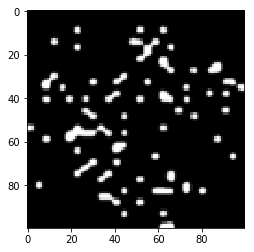

In [6]:
dirname = 'wafer_data/good_image/good_reformed_pure_black'
good_list = sorted(glob(dirname + '/' + '*.png'))
#good_data = tuple((0, sp.misc.imread(good)) for good in good_list)
good_data = tuple((0, sp.misc.imresize(sp.misc.imread(good), size=(100, 100))) for good in good_list)


print('Good Data : %s' % len(good_data))
print(good_list[1])
plt.imshow(good_data[0][1], cmap='gray')

In [7]:
good_data[0][1]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

# Optional : Pattern Recognizer

In [85]:
def wafer_pattern_recognizer(wafer_array):

    # % Resizing
    square_shape = (300, 300)
    resized = sp.misc.imresize(wafer_array, size=square_shape, interp='lanczos')  # nearest : binary | lanczos
    #plt.imshow(resized)

    # % Denoising
    #denoised = cv2.fastNlMeansDenoising(resized, None, 40, 11, 21)
    denoised = denoise_tv_chambolle(resized, weight=0.3, multichannel=True)
    #plt.imshow(denoised)

    # % Thresholding
    #local_thresholded = filters.threshold_local(denoised, block_size=21, method='gaussian', mode='reflect')
    #threshold = filters.threshold_mean(thresholded)
    threshold = filters.threshold_minimum(denoised)
    thresholded = np.where(denoised > threshold, 255, 0)
    #plt.imshow(thresholded)

    # % Line Detection
    edge_pts = np.array(np.nonzero(thresholded), dtype=float).T
    edge_pts_xy = edge_pts#[:, ::-1]
    #edge_pts_xy = edge_pts
    
    marked = np.zeros(square_shape)
    for i in range(3):
        model_robust, inliers = ransac(edge_pts_xy, CircleModel, min_samples=3,
                                           residual_threshold=2, max_trials=300)

        # Only for Assignment in 'white_wafer'
        [marked.__setitem__((x, y), 1) for x, y in edge_pts[inliers,].astype(int)]
        
    return marked


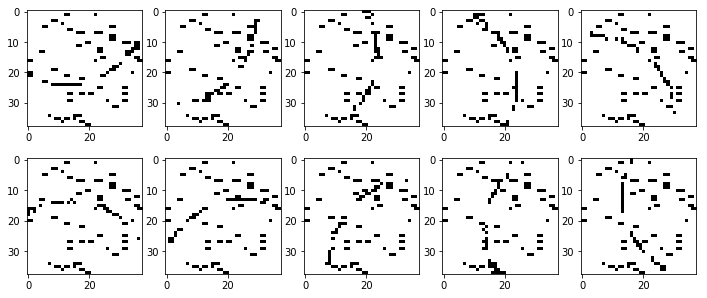

In [90]:
bad_sample = tuple(bad[1] for bad in bad_data[:10])

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 5))
axes = axes.ravel()
for patt, ax in zip(bad_sample, axes):
    ax.imshow(patt, cmap='gray')

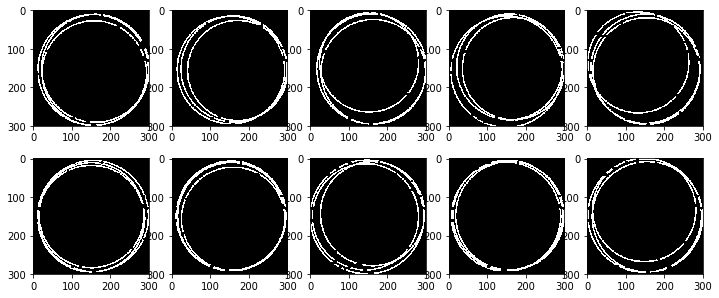

In [88]:
result = [wafer_pattern_recognizer(bad[1]) for bad in bad_sample]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 5))
axes = axes.ravel()
for patt, ax in zip(result, axes):
    ax.imshow(patt, cmap='gray')

# Tensorflow : CNN

### Check The shape of images

In [8]:
print(bad_data[0][1].shape)
print(good_data[0][1].shape)
print(300 * 300)

(100, 100)
(100, 100)
90000


### One-hot Encoding

In [9]:
data = bad_data + good_data
print('Bad & Good : %s' % len(data))
train, test = model_selection.train_test_split(data, train_size=.6, test_size=.4, random_state=11)

# Labels
train_label = np.array(tuple(item[0] for item in train), dtype=np.float32)
test_label = np.array(tuple(item[0] for item in test), dtype=np.float32)

# Images
#train_image = np.array(tuple(item[1] for item in train), dtype=np.uint8)
#test_image = np.array(tuple(item[1] for item in test), dtype=np.uint8)
train_image = np.stack((item[1].astype(np.float32).reshape((100 * 100,)) for item in train))#.astype(np.float32)
test_image = np.stack((item[1].astype(np.float32).reshape((100 * 100,)) for item in test))#.astype(np.float32)

Bad & Good : 180000


In [10]:
train_image[0]

array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32)

In [11]:
print('Train : %s' % len(train))
print('Test : %s' % len(test))

Train : 108000
Test : 72000


In [12]:
train_label[0]

1.0

In [13]:
n_class = len(set(tuple(item[0] for item in data)))

train_onehot = tf.one_hot(indices = train_label,
                          depth = n_class,
                          on_value = 1.,
                          off_value = 0.,
                          axis = -1)  # col : -1, idx : 0

test_onehot = tf.one_hot(indices = test_label,
                         depth = n_class,
                         on_value = 1.,
                         off_value = 0.,
                         axis = -1)  # col : -1, idx : 0

In [14]:
# Training Parameters

#learningRate = .1
#threshold = .5
#trainingEpochs = 1000
#displayStep = 100

learning_rate = .001
num_steps = 1000
batch_size = 5

In [15]:
# Network Parameters

num_input = 100 * 100 # data input (img shape)
num_classes = n_class # total classes (0-9 digits)
dropout = .75 # Dropout, probability to keep units

In [16]:
24 * 24

576

## Check the shape of the data

In [17]:
train_image[0].shape

(10000,)

In [18]:
train_image[:2]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [19]:
train_label[:2]

array([ 1.,  1.], dtype=float32)

## Create the neural network

In [20]:
def conv_net(x_dict, n_classes, dropout, reuse, is_training):

    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # The data input is a 1-D vector of 1444 features (38*38 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 100, 100, 1])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out

## Define the model function (following TF Estimator Template)

In [21]:
def model_fn(features, labels, mode):
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False,
                            is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True,
                           is_training=False)

    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)

    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes)

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op,
                                  global_step=tf.train.get_global_step())

    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=pred_classes,
        loss=loss_op,
        train_op=train_op,
        eval_metric_ops={'accuracy': acc_op})

    return estim_specs

# Build the Estimator
model = tf.estimator.Estimator(model_fn)

# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.train.images}, y=mnist.train.labels,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

In [22]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn)

# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': train_image}, y=train_label,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpntruzoeg', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpntruzoeg/model.ckpt.
INFO:tensorflow:loss = 29.2442, step = 1
INFO:tensorflow:global_step/sec: 71.3485
INFO:tensorflow:loss = 0.544296, step = 101 (1.402 sec)
INFO:tensorflow:global_step/sec: 72.8918
INFO:tensorflow:loss = 0.238451, step = 201 (1.372 sec)
INFO:tensorflow:global_step/sec: 72.7725
INFO:tensorflow:loss = 0.00595054, step = 301 (1.374 sec)
INFO:tensorflow:global_step/sec: 72.8519
INFO:tensorflow:loss = 0.000473059, step = 401 (1.373 sec)
INFO:tensorflow:global_step/sec: 72.7718
INFO:tensorflow:loss = 0.128493, step = 501 (1.374 sec)
INFO:tenso

# Test the Model

In [23]:
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': test_image}, y=test_label,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
e = model.evaluate(input_fn)

print("Testing Accuracy:", e['accuracy'])

INFO:tensorflow:Starting evaluation at 2017-10-09-07:30:01
INFO:tensorflow:Restoring parameters from /tmp/tmpntruzoeg/model.ckpt-1000
INFO:tensorflow:Finished evaluation at 2017-10-09-07:32:04
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.98325, global_step = 1000, loss = 0.0767254
Testing Accuracy: 0.98325


Done.